user_id
activity
timestamp
x-axis
y-axis
z-axis
x-rotate
y-rotate
z-rotate
arms
rrms
roll
pitch
38069
break :  0
pushup :  2618
sidebend :  11066
sidecrunch :  4782
situp :  10369
squat :  9234


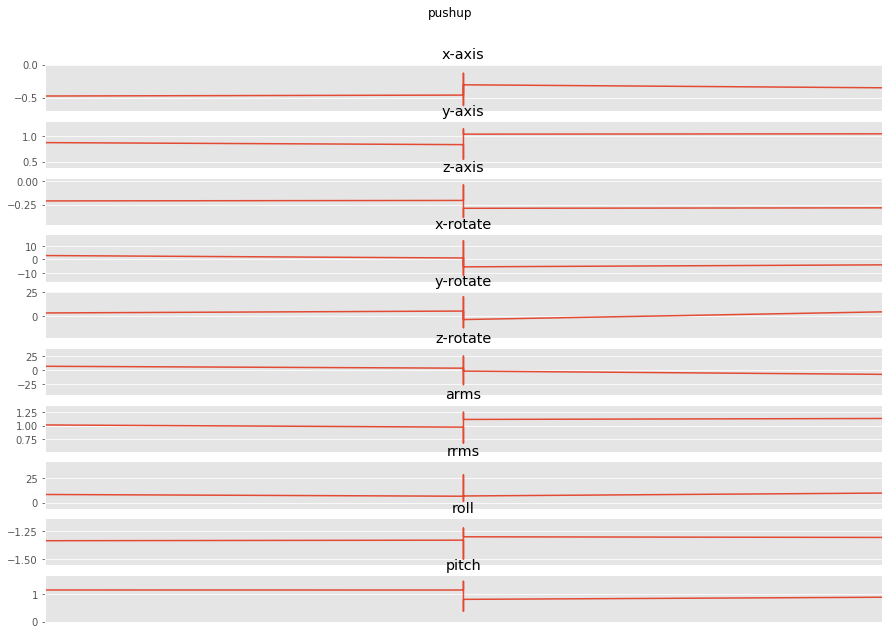

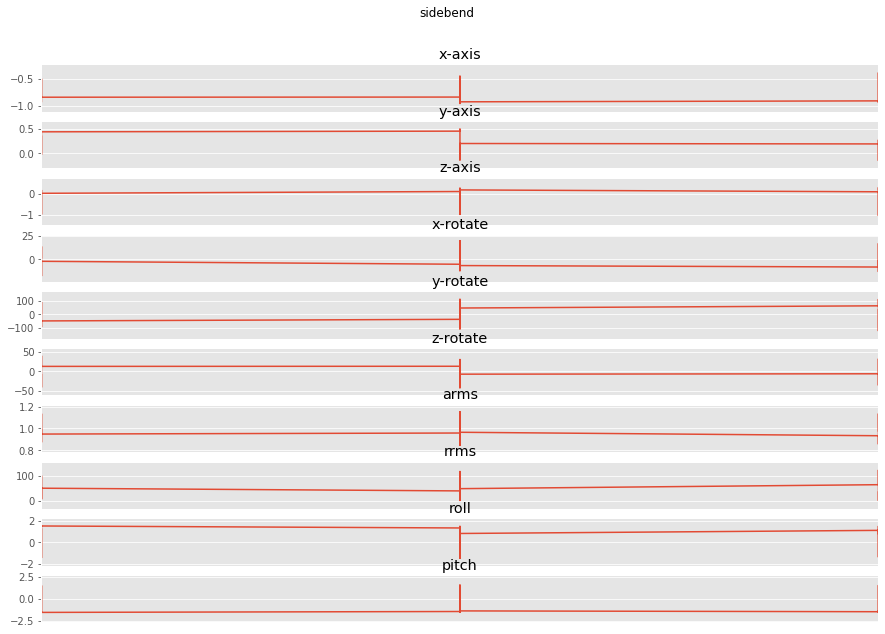

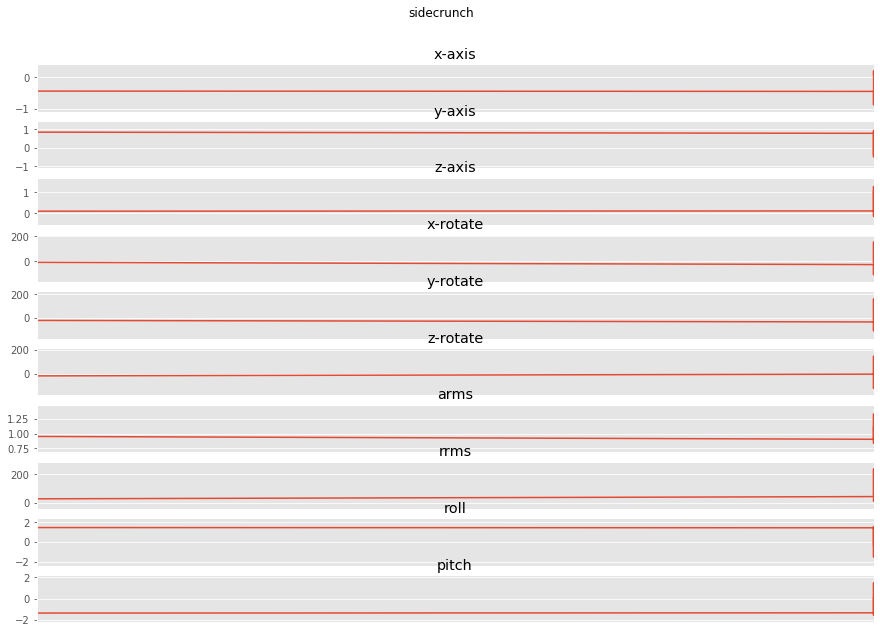

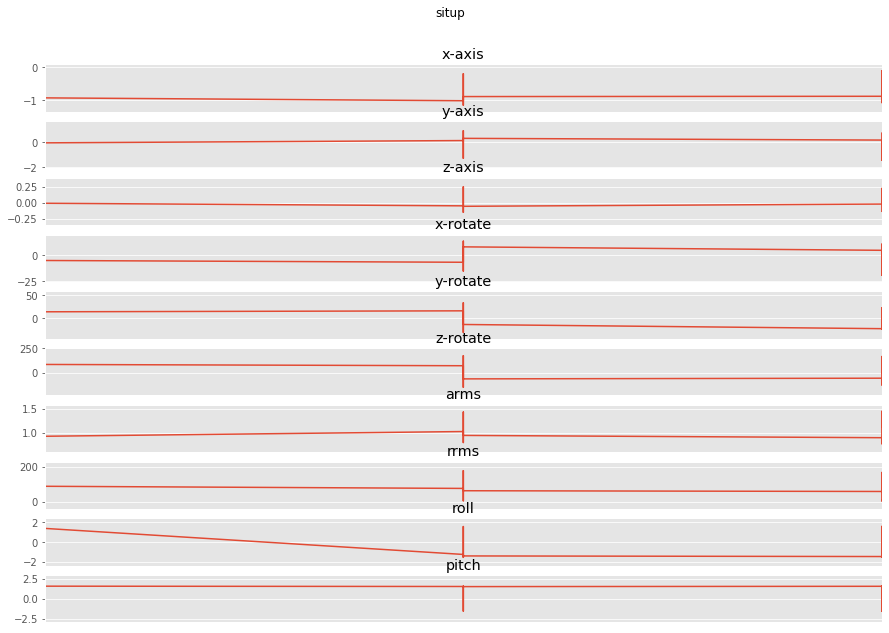

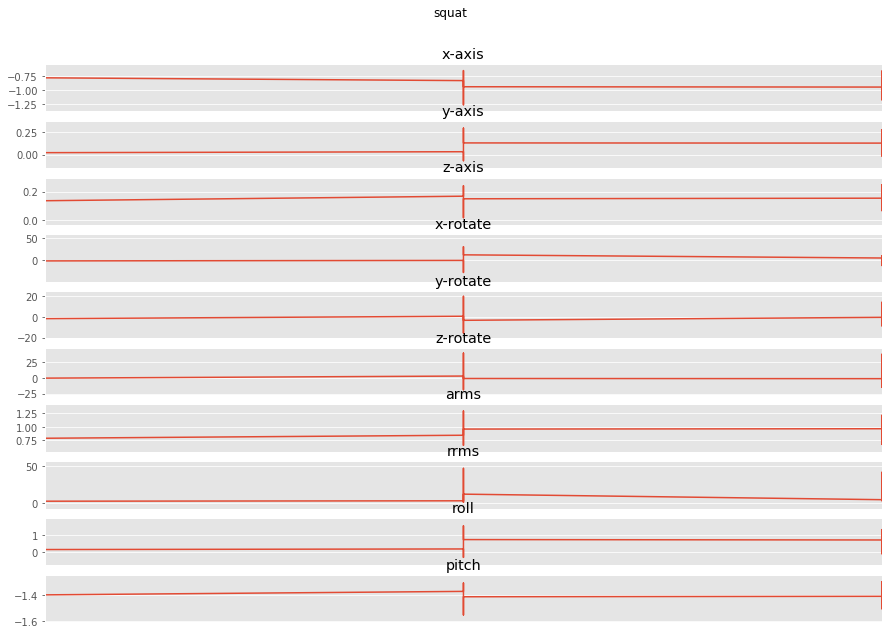

---------------------
30 10
---------------------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 29, 9, 128)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 4, 128)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 4, 128)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7168)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               917632    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dens

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep 27 14:34:20 2017
This is a small project for CNN in KERAS.
This file creates, trains and save a convolutional neural network for
Human Acitivity Recognition. The data we used for this file is released and provided by
Wireless Sensor Data Mining (WISDM) lab and can be found on this link.
http://www.cis.fordham.edu/wisdm/dataset.php  
Feel free to use this code and site this repositry if you use it for your reports or project.
@author: Muhammad Shahnawaz
"""
# importing libraries and dependecies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
#from keras import backend as K
from tensorflow.keras import optimizers
#K.set_image_dim_ordering('th')
# setting up a random seed for reproducibility
random_seed = 611
np.random.seed(random_seed)

# matplotlib inline
plt.style.use('ggplot')
# defining function for loading the dataset
def readData(filePath):
    # attributes of the dataset
    columnNames = ['user_id','activity','timestamp','x-axis','y-axis','z-axis','x-rotate','y-rotate','z-rotate','arms','rrms','roll','pitch']
    data = pd.read_csv(filePath,header = None, names=columnNames,na_values=';')
    return data
# defining a function for feature normalization
# (feature - mean)/stdiv

# defining the function to plot a single axis data
def plotAxis(axis,x,y,title):
    y=y.astype(np.float64)
    axis.plot(x,y)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y),max(y)+np.std(y)])
    axis.set_xlim([min(x),max(x)])
    axis.grid(True)
    
# defining a function to plot the data for a given activity
def plotActivity(activity,data):
    fig,(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9) = plt.subplots(nrows=10, figsize=(15,10),sharex=True)
    plotAxis(ax0,data['timestamp'],data['x-axis'],'x-axis')
    plotAxis(ax1,data['timestamp'],data['y-axis'],'y-axis')
    plotAxis(ax2,data['timestamp'],data['z-axis'],'z-axis')
    plotAxis(ax3,data['timestamp'],data['x-rotate'],'x-rotate')
    plotAxis(ax4,data['timestamp'],data['y-rotate'],'y-rotate')
    plotAxis(ax5,data['timestamp'],data['z-rotate'],'z-rotate')
    plotAxis(ax6,data['timestamp'],data['arms'],'arms')
    plotAxis(ax7,data['timestamp'],data['rrms'],'rrms')
    plotAxis(ax8,data['timestamp'],data['roll'],'roll')
    plotAxis(ax9,data['timestamp'],data['pitch'],'pitch')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()
    
# defining a window function for segmentation purposes
def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= (size/2)
# segmenting the time series
def segment_signal(data, window_size = 30): # 원래는 90
    segments = np.empty((0,window_size,10))
    labels= np.empty((0))
    for (start, end) in windows(data['timestamp'],window_size):
        x = data['x-axis'][start:end]
        y = data['y-axis'][start:end]
        z = data['z-axis'][start:end]
        a = data['x-rotate'][start:end]
        b = data['y-rotate'][start:end]
        c = data['z-rotate'][start:end]
        d = data['arms'][start:end]
        e = data['rrms'][start:end]
        f = data['roll'][start:end]
        g = data['pitch'][start:end]
        
        if(len(data['timestamp'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z,a,b,c,d,e,f,g])])
            labels = np.append(labels,stats.mode(data['activity'][start:end])[0][0])
    return segments, labels
''' Main Code '''
# # # # # # # # #   reading the data   # # # # # # # # # # 
# Path of file #

#dataset = readData('0721_Add_sidebend_learningdata_sort.txt') 
#dataset = readData('0504_total_data_col_13.txt')

#dataset = readData('x_sidebend_내꺼만 추가 안함.txt')
#dataset = readData('x_sidecrunch_다곤 left1, 민지 데이터 반영 안함.txt')

dataset = readData('end-no-break.txt') # end 사이드 크런치, 사이드 벤드 모두 반영 
# fair2 는 break 더 많이 추가한거

for i in dataset:
    print(i)
print(len(dataset))

print('break : ',dataset['activity'].tolist().count('break'))
print('pushup : ',dataset['activity'].tolist().count('pushup'))
print('sidebend : ',dataset['activity'].tolist().count('sidebend'))
print('sidecrunch : ',dataset['activity'].tolist().count('sidecrunch'))
print('situp : ',dataset['activity'].tolist().count('situp'))
print('squat : ',dataset['activity'].tolist().count('squat'))

# plotting a subset of the data to visualize

for activity in np.unique(dataset['activity']):
    subset = dataset[dataset['activity']==activity][:180]
    plotActivity(activity,subset)

    
# segmenting the signal in overlapping windows of 90 samples with 50% overlap
segments, labels = segment_signal(dataset) 
#categorically defining the classes of the activities
labels = np.asarray(pd.get_dummies(labels),dtype = np.int8)
# defining parameters for the input and network layers
# we are treating each segmeent or chunk as a 2D image (90 X 3)
numOfRows = segments.shape[1]
numOfColumns = segments.shape[2]
print('---------------------')
print(numOfRows,numOfColumns)
print('---------------------')
numChannels = 1
numFilters = 128 # number of filters in Conv2D layer
# kernal size of the Conv2D layer
kernalSize1 = 2
# max pooling window size
poolingWindowSz = 2
# number of filters in fully connected layers
numNueronsFCL1 = 128
numNueronsFCL2 = 128
# split ratio for test and validation
trainSplitRatio = 0.8
# number of epochs
Epochs = 10
# batchsize
batchSize = 10
# number of total clases
numClasses = labels.shape[1]

# dropout ratio for dropout layer
dropOutRatio = 0.2
# reshaping the data for network input
reshapedSegments = segments.reshape(segments.shape[0], numOfRows, numOfColumns,1)
# splitting in training and testing data
trainSplit = np.random.rand(len(reshapedSegments)) < trainSplitRatio
trainX = reshapedSegments[trainSplit]
testX = reshapedSegments[~trainSplit]
trainX = np.nan_to_num(trainX)
testX = np.nan_to_num(testX)


trainY = labels[trainSplit]
testY = labels[~trainSplit]

def cnnModel():
    model = Sequential()
    # adding the first convolutionial layer with 32 filters and 5 by 5 kernal size, using the rectifier as the activation function
    model.add(Conv2D(numFilters, (kernalSize1,kernalSize1),input_shape=(numOfRows, numOfColumns,1),activation='relu'))
    # adding a maxpooling layer
    model.add(MaxPooling2D(pool_size=(poolingWindowSz,poolingWindowSz),padding='valid'))
    # adding a dropout layer for the regularization and avoiding over fitting
    model.add(Dropout(dropOutRatio))
    # flattening the output in order to apply the fully connected layer
    model.add(Flatten())
    # adding first fully connected layer with 256 outputs
    model.add(Dense(numNueronsFCL1, activation='relu'))
    #adding second fully connected layer 128 outputs
    model.add(Dense(numNueronsFCL2, activation='relu'))
    # adding softmax layer for the classification
    model.add(Dense(numClasses, activation='softmax'))
    # Compiling the model to generate a model
    adam = optimizers.Adam(lr = 0.001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model
model = cnnModel()
model.summary()
for layer in model.layers:
    print(layer.name)
trainX=trainX.astype(np.float64)
model.fit(trainX,trainY, validation_split=1-trainSplitRatio,epochs=50,batch_size=batchSize,verbose=2)
score = model.evaluate(testX,testY,verbose=2)
print('Baseline Error: %.2f%%' %(100-score[1]*100))
model.save('model.h5')

np.save('model_groundTruth.npy',testY)
np.save('model_testData.npy',testX)
